Mounted at /content/drive
loading annotations into memory...
Done (t=28.03s)
creating index...
index created!


Generating masks: 100%|██████████| 20000/20000 [02:35<00:00, 128.56it/s]


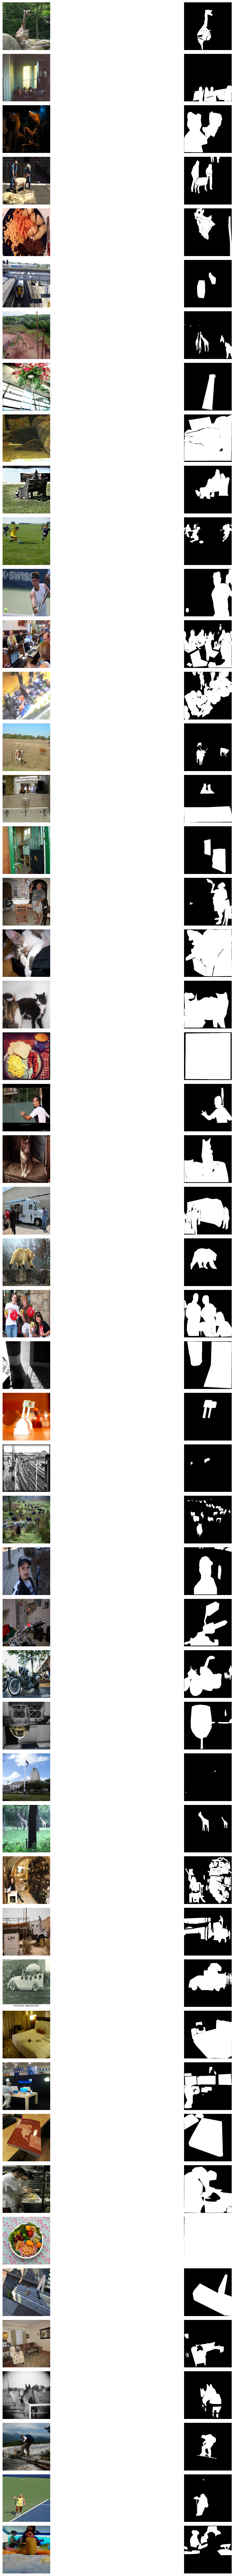

In [4]:
!pip install -q pycocotools tqdm

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, zipfile, random, urllib.request, shutil, time
from tqdm import tqdm
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

BASE = "/content/coco20k"
IM_DIR = os.path.join(BASE, "images")
MASK_DIR = os.path.join(BASE, "masks")
ANN_DIR = os.path.join(BASE, "annotations")
os.makedirs(IM_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)
os.makedirs(ANN_DIR, exist_ok=True)

ANNOTATIONS_ZIP_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
ANNOTATIONS_ZIP_LOCAL = os.path.join("/content", "ann_trainval2017.zip")
ANNOTATIONS_JSON = os.path.join(ANN_DIR, "annotations", "instances_train2017.json")

if not os.path.exists(ANNOTATIONS_JSON):
    urllib.request.urlretrieve(ANNOTATIONS_ZIP_URL, ANNOTATIONS_ZIP_LOCAL)
    with zipfile.ZipFile(ANNOTATIONS_ZIP_LOCAL, 'r') as z:
        z.extractall(ANN_DIR)

coco = COCO(ANNOTATIONS_JSON)
all_img_ids = coco.getImgIds()
N = 20000
N = min(N, len(all_img_ids))
selected_ids = random.sample(all_img_ids, N)

def download_image(file_name, dst_dir):
    url = f"http://images.cocodataset.org/train2017/{file_name}"
    dst = os.path.join(dst_dir, file_name)
    if os.path.exists(dst):
        return True
    try:
        urllib.request.urlretrieve(url, dst)
        return True
    except:
        return False

failed = 0
for img_id in tqdm(selected_ids, desc="Downloading images"):
    info = coco.loadImgs(img_id)[0]
    fname = info['file_name']
    ok = download_image(fname, IM_DIR)
    if not ok:
        failed += 1

for img_id in tqdm(selected_ids, desc="Generating masks"):
    info = coco.loadImgs(img_id)[0]
    fname = info['file_name']
    img_path = os.path.join(IM_DIR, fname)
    if not os.path.exists(img_path):
        continue
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    h, w = info['height'], info['width']
    mask = np.zeros((h, w), dtype=np.uint8)
    for ann in anns:
        try:
            m = coco.annToMask(ann)
            mask = np.logical_or(mask, m)
        except:
            continue
    mask = (mask.astype(np.uint8) * 255)
    cv2.imwrite(os.path.join(MASK_DIR, fname.replace('.jpg', '.png')), mask)

PEOPLE_SRC = "/content/people_segmentation/people_segmentation"
COMB_IMG = "/content/multi_object/images"
COMB_MASK = "/content/multi_object/masks"
os.makedirs(COMB_IMG, exist_ok=True)
os.makedirs(COMB_MASK, exist_ok=True)

for f in os.listdir(IM_DIR):
    shutil.copy(os.path.join(IM_DIR, f), os.path.join(COMB_IMG, f))
for f in os.listdir(MASK_DIR):
    shutil.copy(os.path.join(MASK_DIR, f), os.path.join(COMB_MASK, f))

if os.path.exists(PEOPLE_SRC):
    pimg = os.path.join(PEOPLE_SRC, "images")
    pmask = os.path.join(PEOPLE_SRC, "masks")
    if os.path.exists(pimg) and os.path.exists(pmask):
        for f in os.listdir(pimg):
            dst_img = os.path.join(COMB_IMG, f)
            if not os.path.exists(dst_img):
                shutil.copy(os.path.join(pimg, f), dst_img)
        for f in os.listdir(pmask):
            dst_mask = os.path.join(COMB_MASK, f)
            if not os.path.exists(dst_mask):
                shutil.copy(os.path.join(pmask, f), dst_mask)

combined_imgs = sorted([f for f in os.listdir(COMB_IMG) if f.lower().endswith(('.jpg','.jpeg','.png'))])
paired = []
for img_name in combined_imgs:
    mask_name = img_name.rsplit('.',1)[0] + ".png"
    if os.path.exists(os.path.join(COMB_MASK, mask_name)):
        paired.append((img_name, mask_name))

random.shuffle(paired)
split_idx = int(0.8 * len(paired))
train_pairs = paired[:split_idx]
val_pairs = paired[split_idx:]

train_img_dir = "/content/multi_object_train/images"
train_mask_dir = "/content/multi_object_train/masks"
val_img_dir   = "/content/multi_object_val/images"
val_mask_dir  = "/content/multi_object_val/masks"
for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
    os.makedirs(d, exist_ok=True)

for img, mask in train_pairs:
    shutil.copy(os.path.join(COMB_IMG, img), os.path.join(train_img_dir, img))
    shutil.copy(os.path.join(COMB_MASK, mask), os.path.join(train_mask_dir, mask))
for img, mask in val_pairs:
    shutil.copy(os.path.join(COMB_IMG, img), os.path.join(val_img_dir, img))
    shutil.copy(os.path.join(COMB_MASK, mask), os.path.join(val_mask_dir, mask))

samples = random.sample(val_pairs, min(50, len(val_pairs)))
plt.figure(figsize=(20, 100))
for i, (img_name, mask_name) in enumerate(samples):
    img = cv2.imread(os.path.join(val_img_dir, img_name))
    img = cv2.cvtColor(cv2.resize(img, (256,256)), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(val_mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256,256))
    plt.subplot(50, 2, 2*i + 1)
    plt.imshow(img); plt.axis('off')
    plt.subplot(50, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.savefig("/content/multi_object_val_50_pairs.png")
plt.show()
